In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymap3d
from demtrack import load_gmat_track, load_csv_track, track_analysis, track_comparison, reference_lla, moon_ellipsoid

The tracking files used below are generated with GMAT and `crash.script`.

IMPACT POINT: Time = 2019-07-31T14:20:03.310932000, Latitude = 16.6858, Longitude = 159.5218, Altitude = -1561.12
With respect to reference: East = -0.4 m, North = 0.5 m , Up = 0.0 m


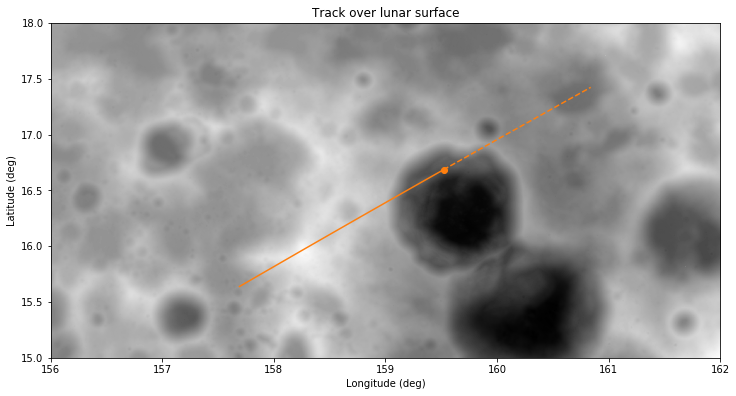

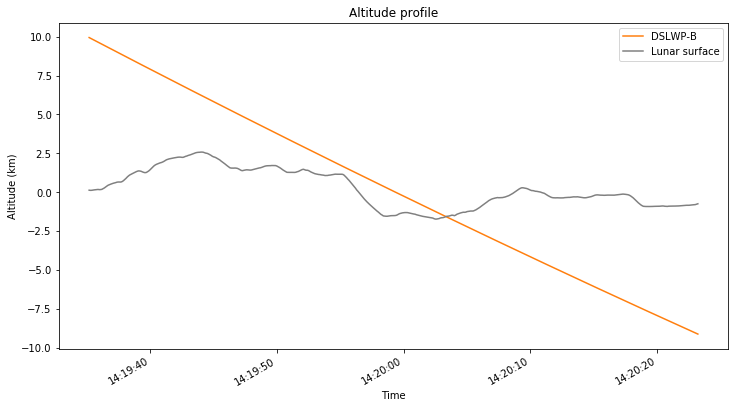

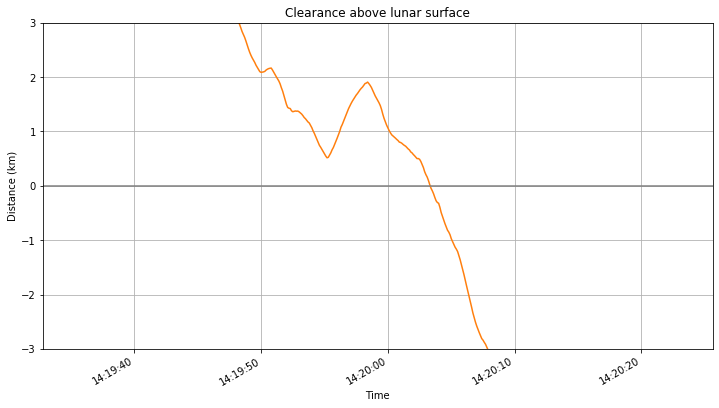

In [2]:
# Luna centred ICRF ephemeris from 2019-07-25
track_analysis(load_gmat_track('dslwp_luna_pos_25jul.txt'))

IMPACT POINT: Time = 2019-07-31T14:19:54.004249000, Latitude = 16.6785, Longitude = 159.5196, Altitude = -1654.19
With respect to reference: East = -64.6 m, North = -221.6 m , Up = -93.1 m


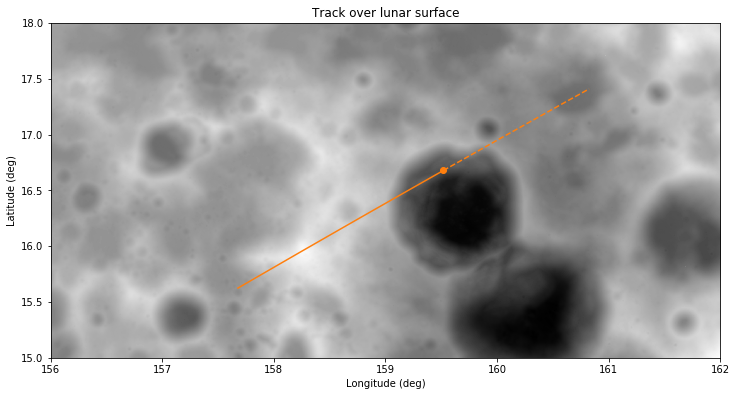

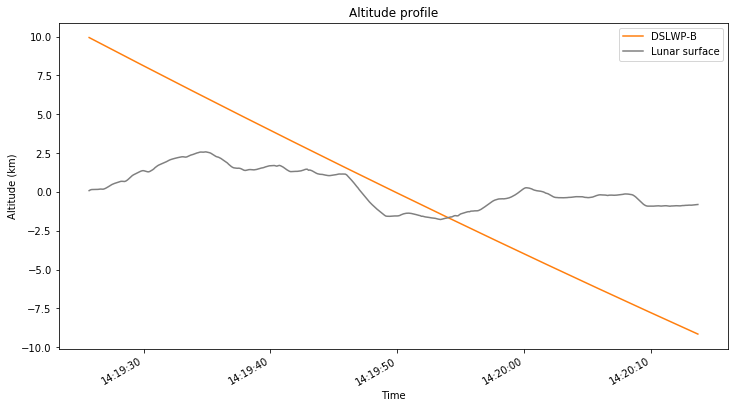

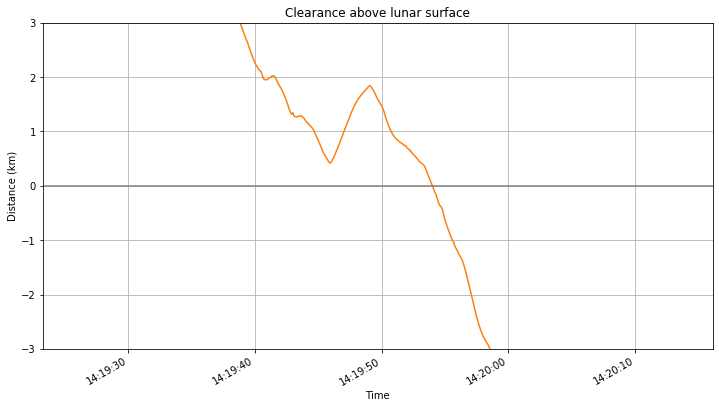

In [3]:
# Luna centred ICRF ephemeris from 2019-07-18
track_analysis(load_gmat_track('dslwp_luna_pos_18jul.txt'))

IMPACT POINT: Time = 2019-07-31T14:18:43.744813000, Latitude = 16.6834, Longitude = 159.5387, Altitude = -1647.23
With respect to reference: East = 490.5 m, North = -72.6 m , Up = -86.2 m


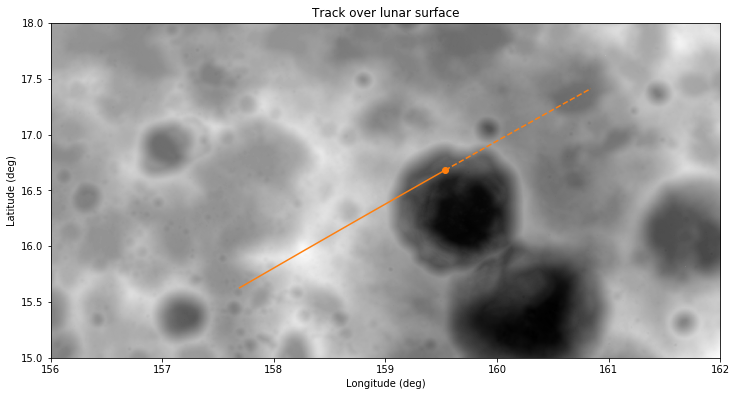

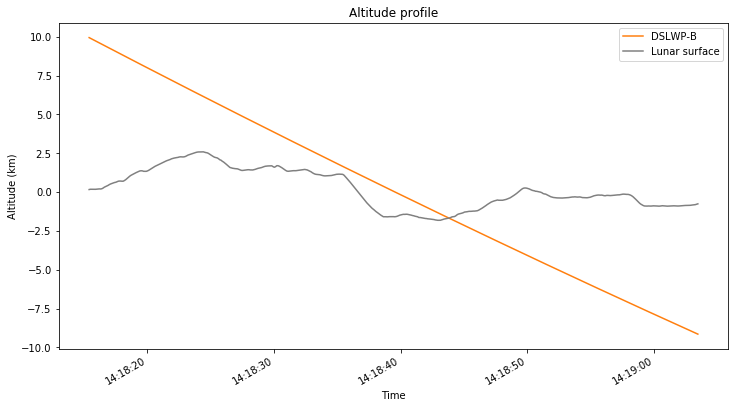

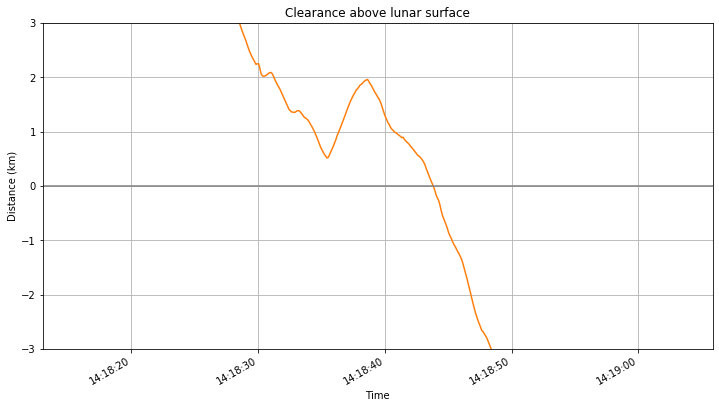

In [4]:
# Luna centred ICRF ephemeris from 2019-06-28
track_analysis(load_gmat_track('dslwp_luna_pos_28jun.txt'))

Impact location obtained by Cees Bassa with CSV file [here](https://github.com/cbassa/dslwp_analysis/blob/master/dslwp_impact.ipynb)

In [5]:
pymap3d.geodetic2enu(16.675, 159.617, 0, reference_lla[0], reference_lla[1], reference_lla[2], ell = moon_ellipsoid)

(2766.3410883251972, -326.94541006886107, 1558.8876808685357)

IMPACT POINT: Time = 2019-07-31T14:20:15.400000000, Latitude = 16.6755, Longitude = 159.6166, Altitude = -1874.87
With respect to reference: East = 2752.9 m, North = -311.6 m , Up = -316.0 m


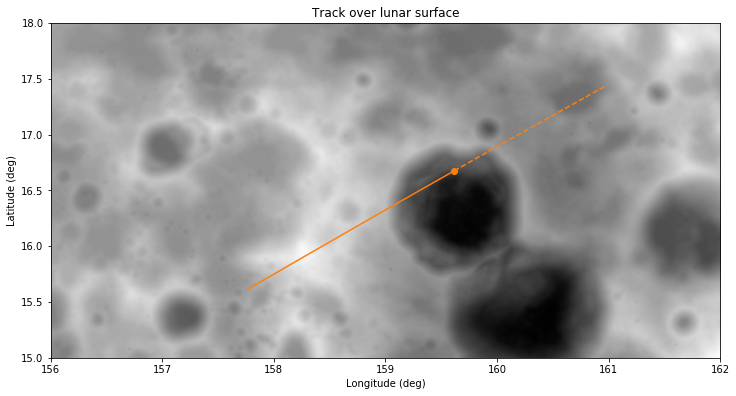

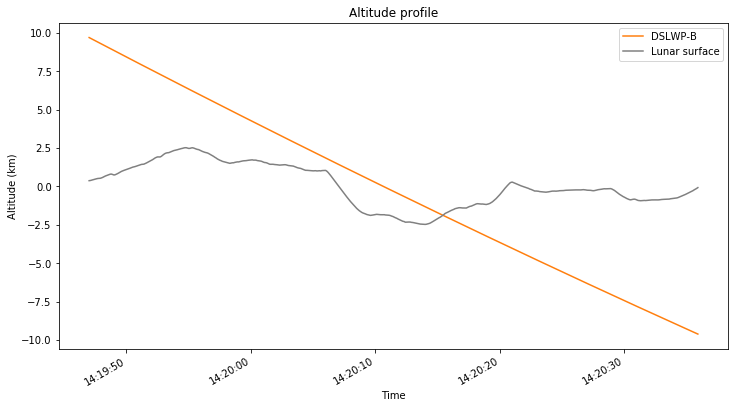

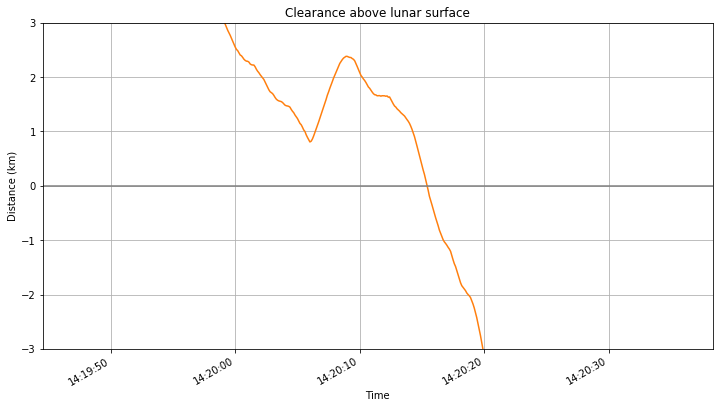

In [6]:
# CSV file computed by Wei Mingchuan BG2BHC
track_analysis(load_csv_track('DSLWP-B1-MOON LLA Position.csv'))

Comparison between track obtained in GMAT and Wei's track. For some reason it seems that Wei's track is displaced to the southeast.

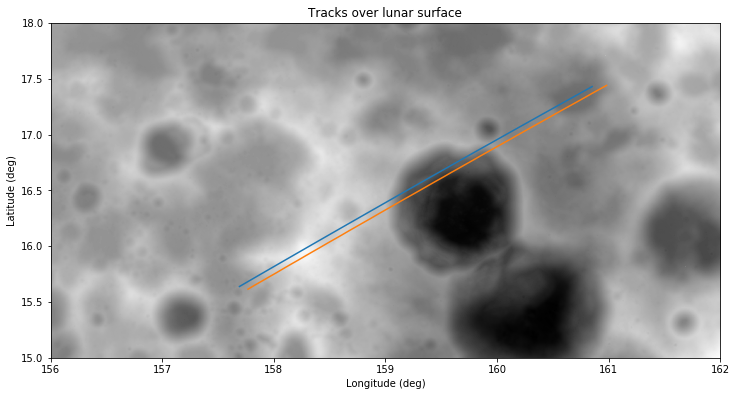

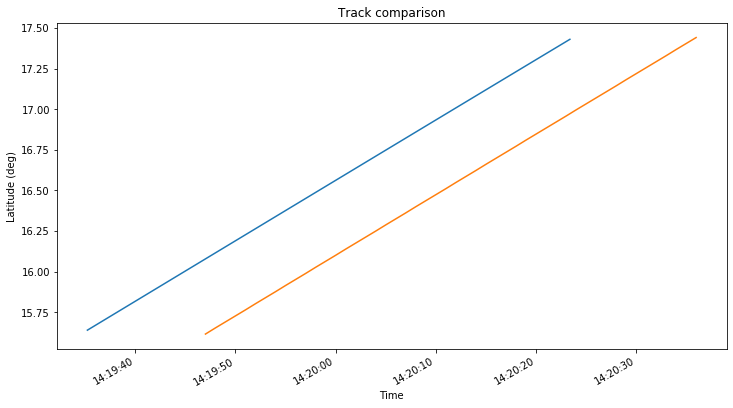

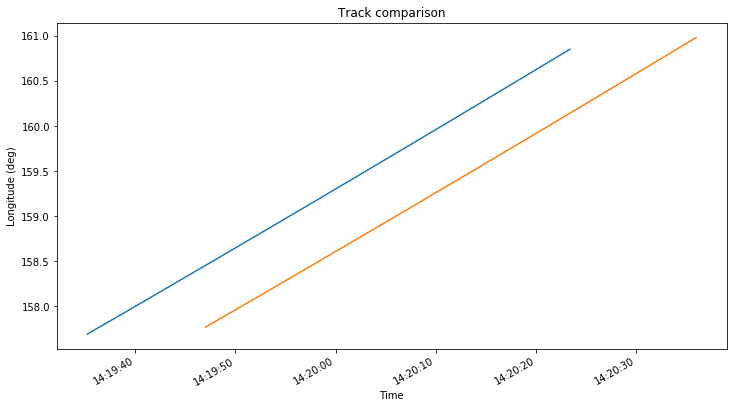

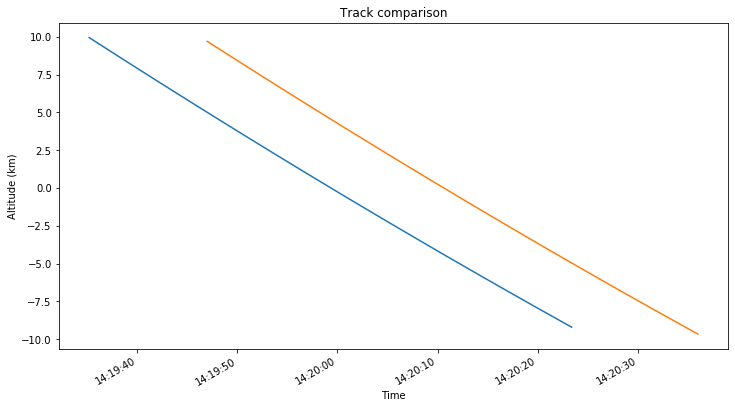

In [7]:
track_comparison(load_gmat_track('dslwp_luna_pos_25jul.txt'), load_csv_track('DSLWP-B1-MOON LLA Position.csv'))

Comparison with a track in GMAT obtained using 1x1 spherical harmonics for the Moon's gravity.

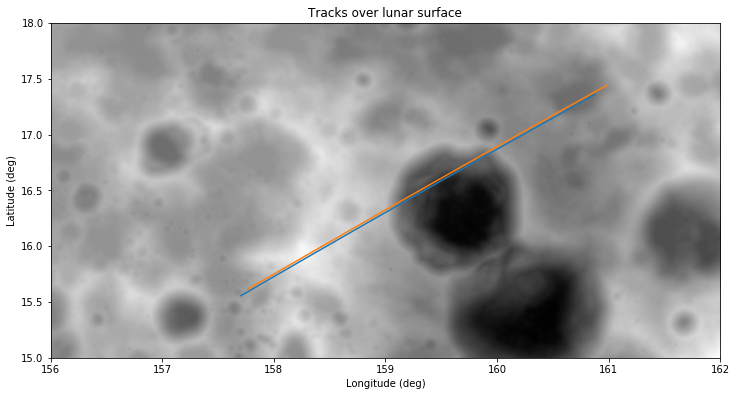

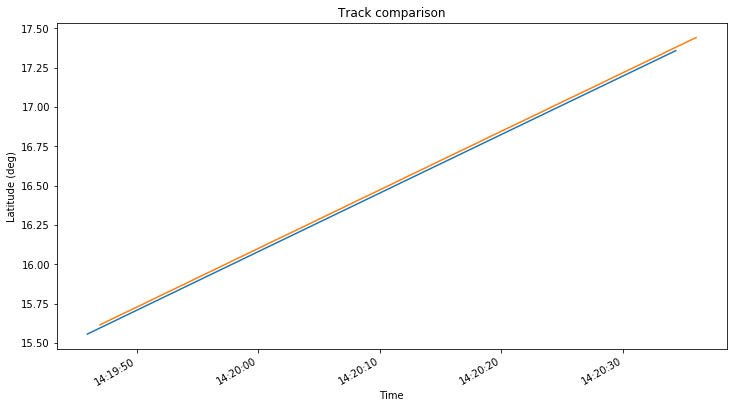

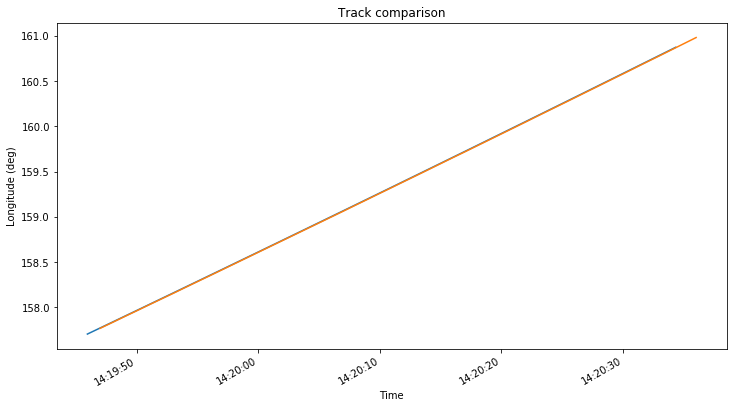

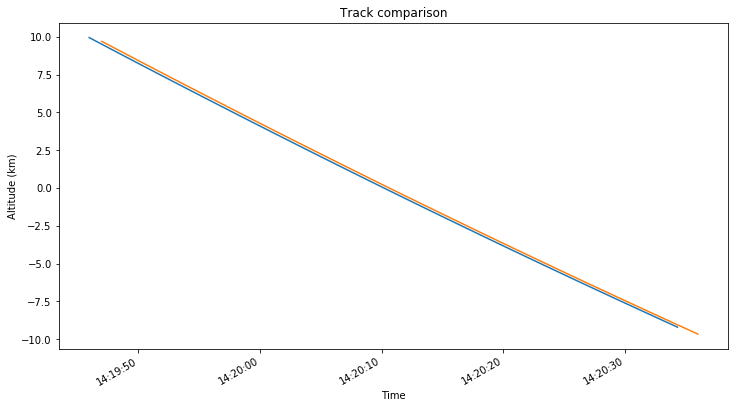

In [8]:
track_comparison(load_gmat_track('dslwp_luna_pos_25jul_grav1x1.txt'), load_csv_track('DSLWP-B1-MOON LLA Position.csv'))

IMPACT POINT: Time = 2019-07-31T14:20:15.557501000, Latitude = 16.6609, Longitude = 159.6318, Altitude = -2106.50
With respect to reference: East = 3192.5 m, North = -752.4 m , Up = -548.5 m


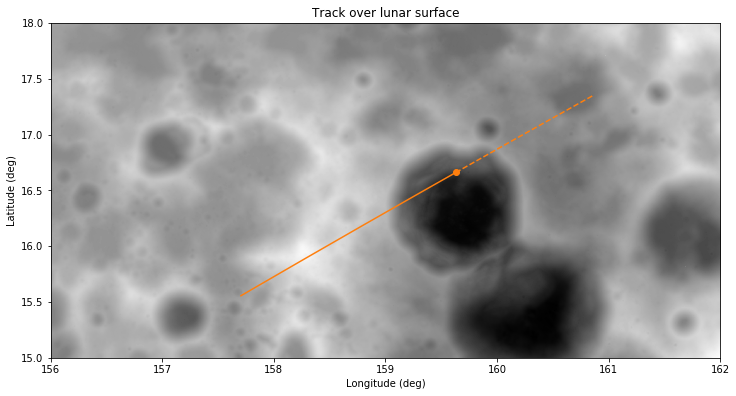

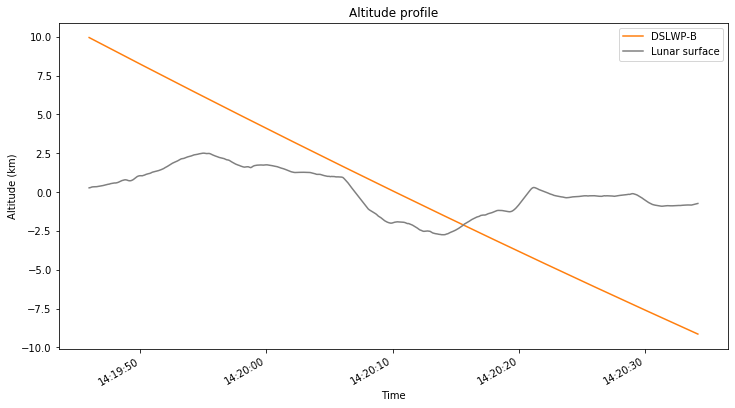

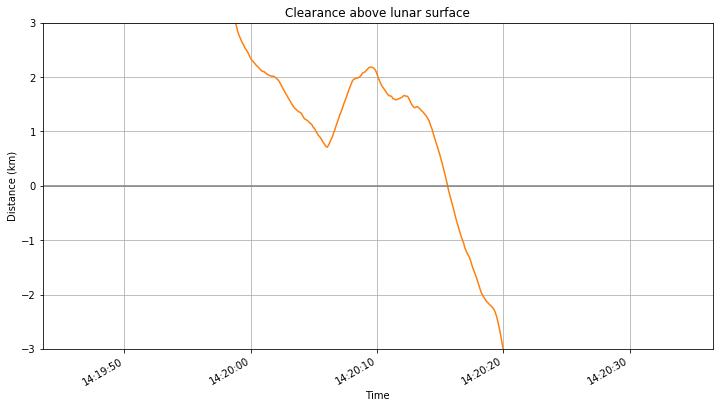

In [9]:
track_analysis(load_gmat_track('dslwp_luna_pos_25jul_grav1x1.txt'))

Evaluation of the effect of not converting from MOON_PA to MOON_ME.

IMPACT POINT: Time = 2019-07-31T14:20:15.257501000, Latitude = 16.6691, Longitude = 159.6267, Altitude = -1989.64
With respect to reference: East = 3043.6 m, North = -504.8 m , Up = -431.3 m


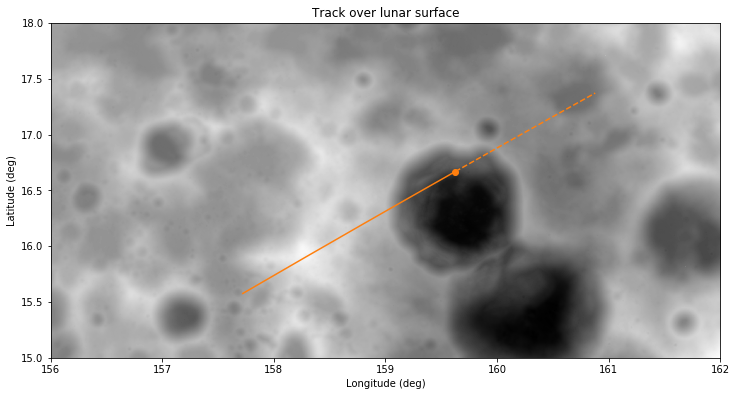

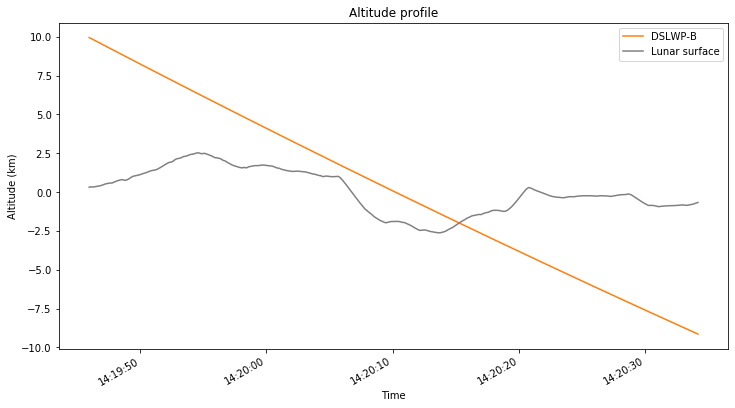

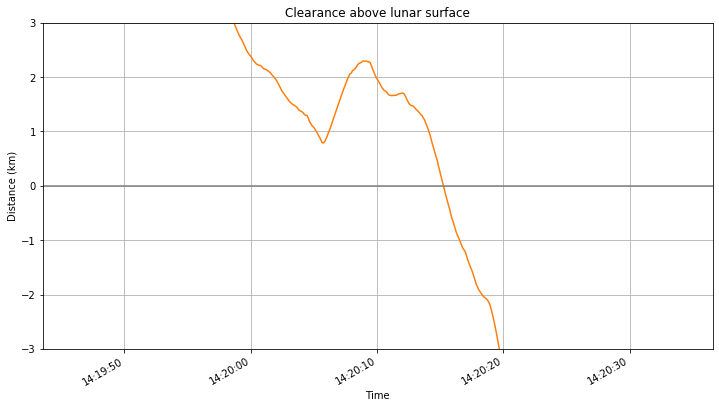

In [10]:
track_analysis(load_gmat_track('dslwp_luna_pos_25jul_grav1x1.txt', skip_pa2me = True))

Assesment of a 2x1 gravity model.

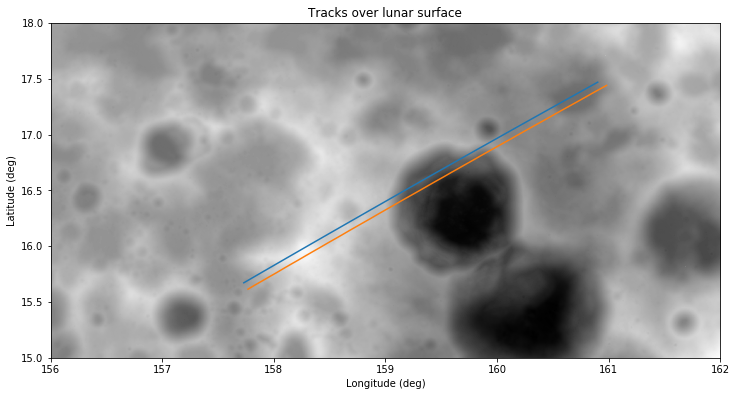

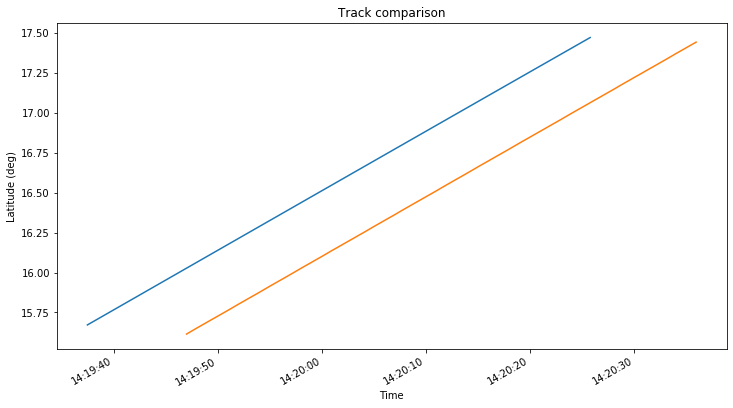

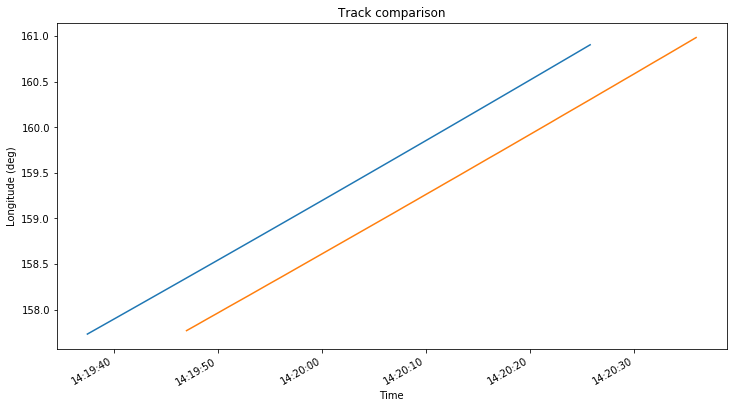

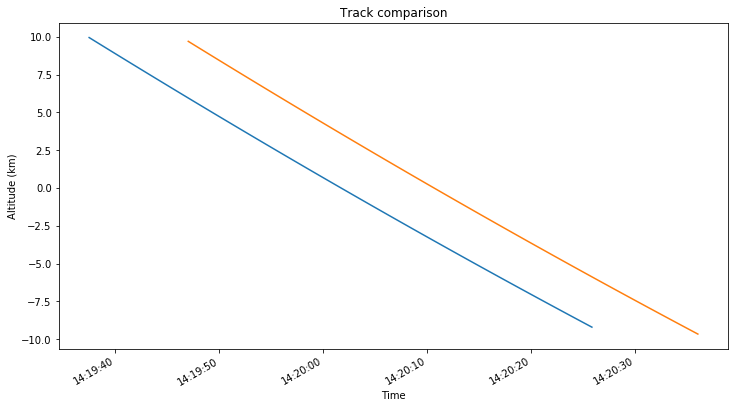

In [14]:
track_comparison(load_gmat_track('dslwp_luna_pos_25jul_grav2x1.txt'), load_csv_track('DSLWP-B1-MOON LLA Position.csv'))

IMPACT POINT: Time = 2019-07-31T14:20:05.267107000, Latitude = 16.7091, Longitude = 159.5432, Altitude = -1408.59
With respect to reference: East = 619.8 m, North = 705.0 m , Up = 152.3 m


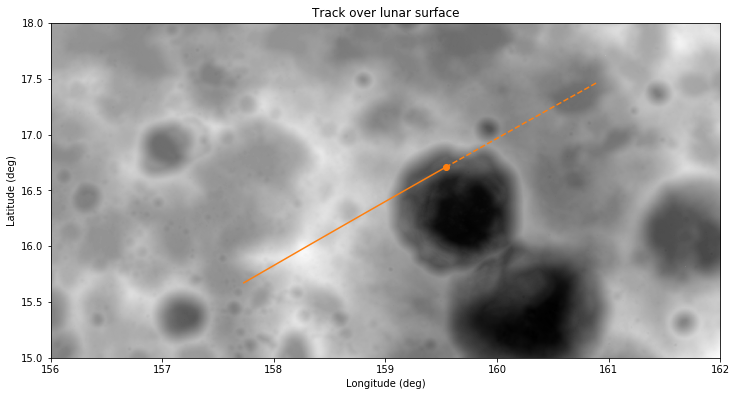

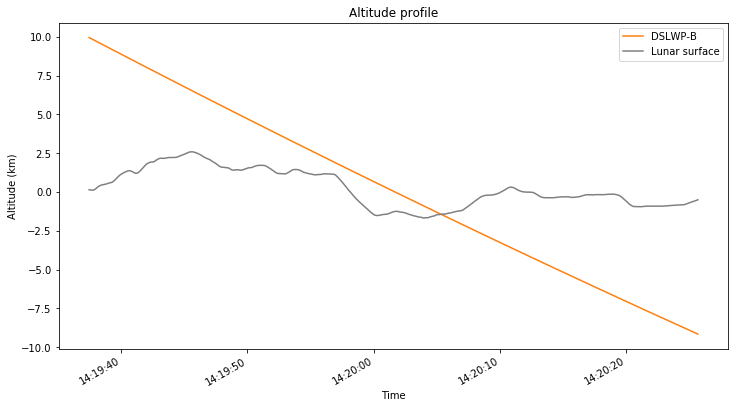

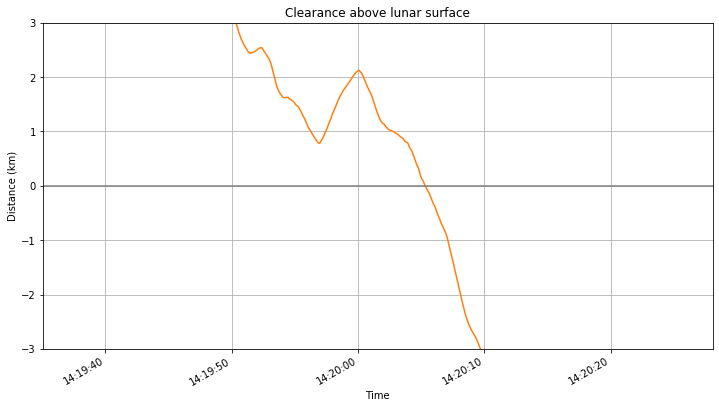

In [15]:
track_analysis(load_gmat_track('dslwp_luna_pos_25jul_grav2x1.txt'))

Assesment of a 20x20 gravity model.

IMPACT POINT: Time = 2019-07-31T14:20:03.408322000, Latitude = 16.6869, Longitude = 159.5241, Altitude = -1559.89
With respect to reference: East = 66.8 m, North = 31.8 m , Up = 1.2 m


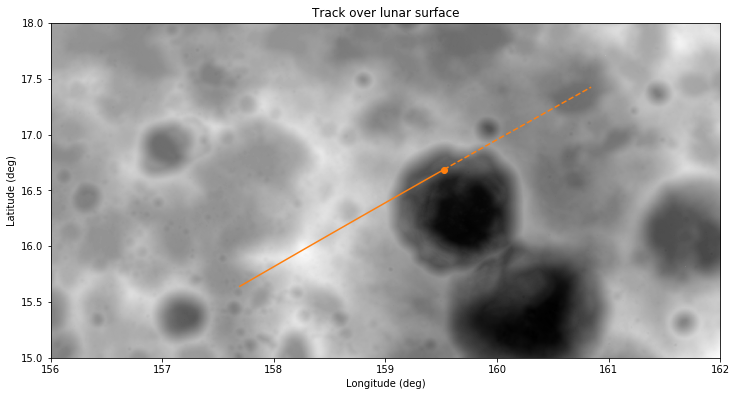

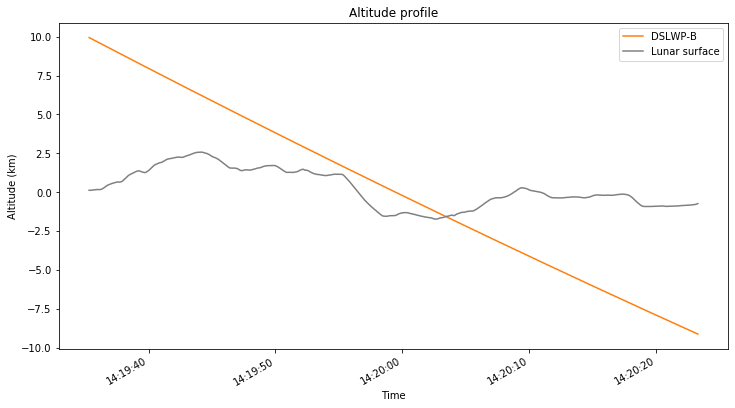

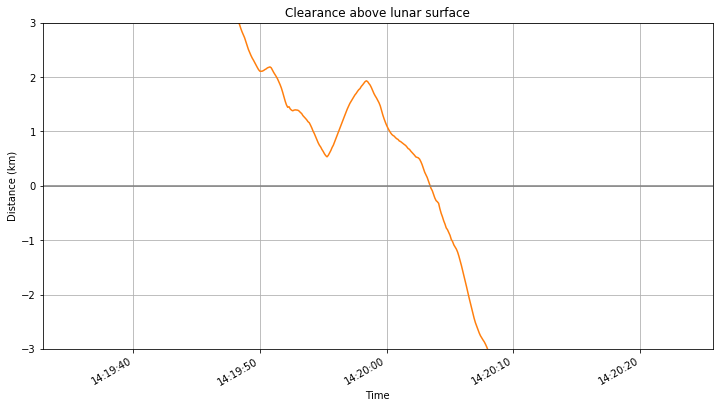

In [19]:
track_analysis(load_gmat_track('dslwp_luna_pos_25jul_grav20x20.txt'))